Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
try:
    data = pd.read_csv(r'C:\Users\kuzmi\Downloads\Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
data.columns = ['Row_Number', 'Customer_Id', 'Surname', 'Credit_Score', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card',
       'Is_Active_Member', 'Estimated_Salary', 'Exited']

In [6]:
data.columns=data.columns.str.lower()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Tenure - сколько лет человек является клиентом банка. Скорее всего, пропуски в этом столбце означают, что ни один год еще не прошел, поэтому заполним пропуски нулями

In [8]:
data['tenure'] = data['tenure'].fillna(0) 

In [9]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [11]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [12]:
data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [13]:
data.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [14]:
data.duplicated().sum()

0

<AxesSubplot:>

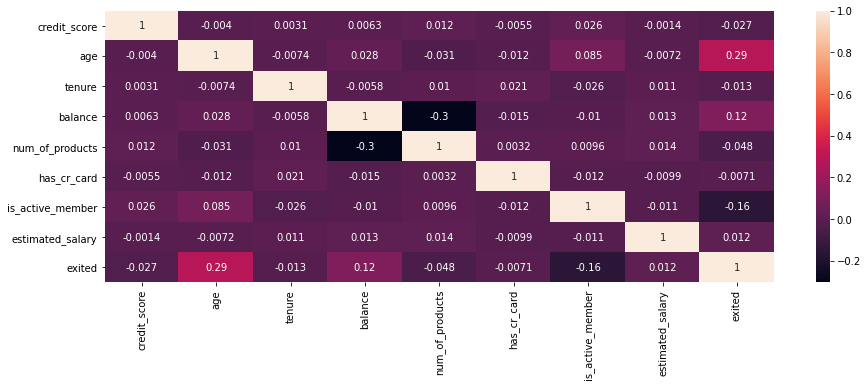

In [15]:
correlation = data.corr()
plt.figure(figsize = (15,5))
sns.heatmap(correlation, annot = True)

Пропусков и дубликатов нет. На матрице корреляции не видно сильных зависимостей - отсуствует мультиколлинеарность, которая могла бы затруднить интерпретацию результатов регрессии.

## 2. Исследование задачи

Gender и geografy - признаки категориальныу, переводим в количественные. Чтобы избежать дамми-ловушки, избавимся от первого столбца

In [16]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [17]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

Делим данные на обучающую, валидационную и тестовую выборки (60:20:20)

In [18]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=12345,
                                                                            stratify=target)

features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [19]:
len(features_train)

6000

In [20]:
len(features_valid)

2000

In [21]:
len(features_test)

2000

Стандартизируем численные признаки

In [22]:
numeric=['credit_score','age','tenure','balance','num_of_products']
scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

/tmp/ipykernel_185/3657596940.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric]=scaler.transform(features_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Посмотрим на баланс классов

In [23]:
data['exited'].value_counts(normalize=1)

0    0.7963
1    0.2037
Name: exited, dtype: float64

### Обучение модели без учета дисбаланса

#### Дерево решений

In [24]:
%%time

best_model = None
best_f1 = 0
for depth in range(1, 25):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=best_depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

NameError: name 'best_depth' is not defined

In [25]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                    max_depth=7)
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)

In [26]:
print("Accuracy_tree:", accuracy_score(target_valid, predictions_valid_tree))
print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

Accuracy_tree: 0.849
Recall_tree: 0.45754716981132076
Precision_tree: 0.7293233082706767
F1_tree: 0.5623188405797102


In [27]:
model_DTC = DecisionTreeClassifier(random_state=12345)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
confusion_matrix(target_valid, DTC_prediction)

array([[1389,  187],
       [ 228,  196]])

#### Случайный лес

In [28]:
%%time

best_model = None

for depth in range(1, 20):
    model_forest = RandomForestClassifier(random_state=12345, max_depth=depth)
    model_forest.fit(features_train, target_train)
    predictions_valid_forest = model_forest.predict(features_valid)
    f1_forest = f1_score(target_valid, predictions_valid_forest)
    if f1_forest > best_f1:
        best_model = model_forest
        best_depth = depth


print('Оптимальная глубина дерева =', best_depth)
print('Качество модели - ', f1_forest)

Оптимальная глубина дерева = 19
Качество модели -  0.556732223903177
CPU times: user 12.8 s, sys: 89.7 ms, total: 12.9 s
Wall time: 12.9 s


In [29]:
best_model = None
best_est = 0
for est in range(1, 16):
    model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=19)
    model_forest.fit(features_train, target_train)
    predictions_valid_forest = model_forest.predict(features_valid)
    f1_forest = f1_score(target_valid, predictions_valid_forest)
    if f1_forest > best_f1:
        best_model = model_forest
        best_est = est


print('Количество деревьев =', best_est)
print('Качество модели - ', f1_forest)

Количество деревьев = 15
Качество модели -  0.5669064748201439


In [30]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=15, 
                                      max_depth=19)
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)

In [31]:
print("Accuracy_forest:", accuracy_score(target_valid, predictions_valid_forest))
print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

Accuracy_forest: 0.8495
Recall_forest: 0.46462264150943394
Precision_forest: 0.7269372693726938
F1_forest: 0.5669064748201439


In [32]:
model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[1522,   54],
       [ 240,  184]])

#### Логистическая регрессия

In [33]:
%%time
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_train, target_train)
predicted_valid_log = model_log.predict(features_valid)

CPU times: user 29.7 ms, sys: 16.2 ms, total: 45.9 ms
Wall time: 31.3 ms


In [34]:
print("Accuracy_log:", accuracy_score(target_valid, predicted_valid_log))
print("Recall_log:", recall_score(target_valid, predicted_valid_log))
print("Precision_log:", precision_score(target_valid, predicted_valid_log))
print("F1_log:", f1_score(target_valid, predicted_valid_log))

Accuracy_log: 0.788
Recall_log: 0.0
Precision_log: 0.0
F1_log: 0.0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[1576,    0],
       [ 424,    0]])

Лучшее значение у модели Случайный лес

## 4. Борьба с дисбалансом

### Увеличение выборки

In [36]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9618, 11)
(9618,)


### Уменьшение выборки

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # fractioning samples
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] +
                                   [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2404, 11)
(2404,)


## Дерево решений после балансировки

In [38]:
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 5
Качество модели -  0.5220588235294118


In [39]:
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 6
Качество модели -  0.5557729941291585


## Случайный лес после балансировки

In [40]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_downsampled, target_downsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [41]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=100, 
                                      max_depth=9)
model_forest.fit(features_downsampled, target_downsampled)
predictions_valid_forest = model_forest.predict(features_valid)

print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_forest:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_forest: 0.7617924528301887
Precision_forest: 0.5135135135135135
F1_forest: 0.6134852801519467
ROC-AUC_forest: 0.865627394406666


In [42]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [43]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=100, 
                                      max_depth=9)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid_forest = model_forest.predict(features_valid)

print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_forest:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_forest: 0.6910377358490566
Precision_forest: 0.5656370656370656
F1_forest: 0.6220806794055201
ROC-AUC_forest: 0.8680502346518532


## Логистическая регрессия после балансировки

In [44]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear')

model_log.fit(features_downsampled, target_downsampled)
predictions_valid_log = model_log.predict(features_valid)

print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_log: 0.6745283018867925
Precision_log: 0.41569767441860467
F1_log: 0.514388489208633
ROC-AUC_log: 0.7757907528014559


In [45]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_log.fit(features_upsampled, target_upsampled)
predictions_valid_log = model_log.predict(features_valid)

print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_log: 0.6863207547169812
Precision_log: 0.3975409836065574
F1_log: 0.5034602076124567
ROC-AUC_log: 0.7787777751173258


Лучший результат показала модель Случайный лес, на ней будем проводить тестирование

# Тестирование модели

Объединим обучающую и тестовую выборки

In [46]:
new_features_test = pd.concat([features_train, features_valid], axis=0, ignore_index=True)
new_target_test = pd.concat([target_train, target_valid], axis=0, ignore_index=True)

In [47]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=12345,
                                              n_estimators=est, 
                                              max_depth=depth,
                                              class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [48]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=100, 
                                      max_depth=9,
                                      class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_test_forest = model_forest.predict(new_features_test)

print("Recall_forest:", recall_score(new_target_test, predictions_test_forest))
print("Precision_forest:", precision_score(new_target_test, predictions_test_forest))
print("F1_tree:", f1_score(new_target_test, predictions_test_forest))

probabilities_test = model_forest.predict_proba(new_features_test)
probabilities_one_test = probabilities_test[:, 1]
print("ROC-AUC_forest:", roc_auc_score(new_target_test, probabilities_one_test))

Recall_forest: 0.7601226993865031
Precision_forest: 0.6894824707846411
F1_tree: 0.7230814123139772
ROC-AUC_forest: 0.9315118798817309


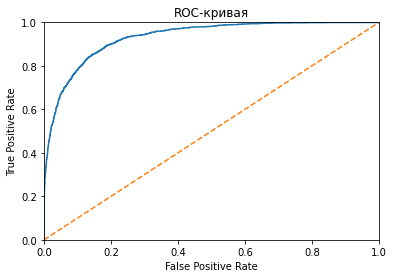

In [49]:
fpr, tpr, thresholds = roc_curve(new_target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr, linestyle='solid')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# Вывод

Модель с предельно большим значением f-меры - модель Случайный лес. При глубине деревьев=9,  и количестве деревьев=100, метрика f=0,72. Заданная метрика 0,59 преодолена. 